<a href="https://colab.research.google.com/github/Zekeriya-Ui/Brownian-motion/blob/main/GWP1_5_9710.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

**Q1**

In [ ]:
def simulate_ovb(n=100, rho=0.8, a=2, b=3, c=5):
    #Simulate data where Y = a + b*X + c*Z + e
    #X and Z are correlated with correlation coefficient rho"""
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    XZ = np.random.multivariate_normal(mean, cov, n)
    X = XZ[:, 0].reshape(-1, 1)
    Z = XZ[:, 1].reshape(-1, 1)
    e = np.random.normal(0, 1, n).reshape(-1, 1)
    Y = a + b * X + c * Z + e
    return X, Z, Y

In [ ]:
# Run simulation
X, Z, Y = simulate_ovb(n=100)
# Full model: Y ~ X + Z
X_full = np.hstack([X, Z])
model_full = LinearRegression().fit(X_full, Y)
b_hat_full = model_full.coef_[0][0]

In [ ]:
# Misspecified model: Y ~ X only
model_miss = LinearRegression().fit(X, Y)
b_hat_miss = model_miss.coef_[0][0]

print("True b:", 3)
print("Estimate of b (Full model):", b_hat_full)
print("Estimate of b (Omitting Z):", b_hat_miss)

sample_sizes = [50, 100, 500, 1000, 5000, 10000]
results = []
for n in sample_sizes:
    X, Z, Y = simulate_ovb(n=n)
    X_full = np.hstack([X, Z])
    b_full = LinearRegression().fit(X_full, Y).coef_[0][0]
    b_miss = LinearRegression().fit(X, Y).coef_[0][0]
    results.append((n, b_full, b_miss))
df = pd.DataFrame(results, columns=["SampleSize", "b_full", "b_miss"])

True b: 3
Estimate of b (Full model): 3.2238680632619747
Estimate of b (Omitting Z): 6.818823350486686


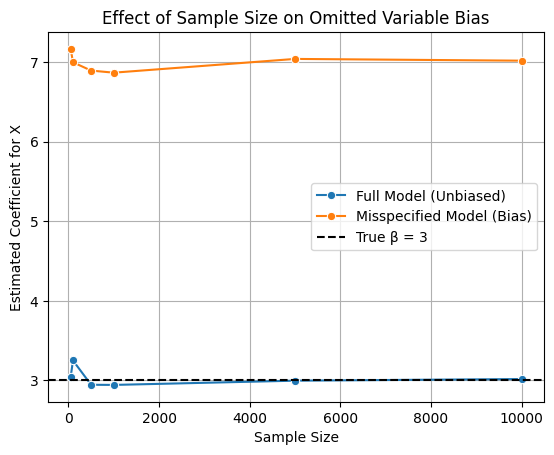

In [ ]:
# Plot results
sns.lineplot(data=df, x="SampleSize", y="b_full", label="Full Model (Unbiased)", marker="o")
sns.lineplot(data=df, x="SampleSize", y="b_miss", label="Misspecified Model (Bias)", marker="o")
plt.axhline(3, color='black', linestyle='--', label="True β = 3")
plt.title("Effect of Sample Size on Omitted Variable Bias")
plt.ylabel("Estimated Coefficient for X")
plt.xlabel("Sample Size")
plt.legend()
plt.grid(True)
plt.show()

**Q2**

Clean model coefficients:
Intercept: 1.8838155018031646
Slope: 3.0026458497244866

With outliers:
Intercept: 2.8845387160503106
Slope: 3.0812010993588665


Text(0.5, 1.0, 'Effect of Outliers on Linear Regression')

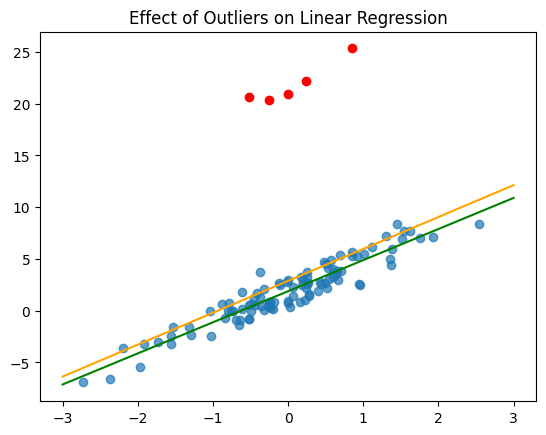

In [ ]:
n = 100
X = np.random.normal(0, 1, size=(n, 1))
epsilon = np.random.normal(0, 1, size=(n, 1))
a, b = 2, 3
Y = a + b * X + epsilon

model_clean = LinearRegression().fit(X, Y)
print("Clean model coefficients:")
print("Intercept:", model_clean.intercept_[0])
print("Slope:", model_clean.coef_[0][0])

Y_outlier = Y.copy()
Y_outlier[0:5] += 20  # Injecting large positive outliers
model_outlier = LinearRegression().fit(X, Y_outlier)
print("\nWith outliers:")
print("Intercept:", model_outlier.intercept_[0])
print("Slope:", model_outlier.coef_[0][0])

plt.scatter(X, Y, label='Clean Data', alpha=0.7)
plt.scatter(X[0:5], Y_outlier[0:5], color='red', label='Outliers')
x_vals = np.linspace(-3, 3, 100).reshape(-1, 1)
plt.plot(x_vals, model_clean.predict(x_vals), label='Fit without Outliers', color='green')
plt.plot(x_vals, model_outlier.predict(x_vals), label='Fit with Outliers', color='orange')
plt.title('Effect of Outliers on Linear Regression')


**Q3**

In [ ]:
df = pd.read_csv('FE-GWP1_model_selection_2.csv')
display(df.head())

,Y,X1,X2,X3,X4,X5
0,2.172296,0.121634,-0.051562,0.570616,1.279931,0.075233
1,0.502380,0.025446,-0.093062,0.304875,-0.582292,0.377388
2,0.711362,-0.136716,-0.082229,-0.191680,-0.647970,1.230986
3,-0.557168,-0.284459,-0.170922,-0.853670,-1.256146,-0.991686
4,1.500199,0.105205,-0.169141,0.826558,0.640945,1.099873


In [ ]:
# Assuming your DataFrame is named 'df' and is already loaded
# Separate features (X) and target (y)
X = df[['X1', 'X2', 'X3', 'X4', 'X5']]
y = df['Y']

# Add a constant (intercept) to the features
X = sm.add_constant(X)

# --- Approach 1: Forward Selection with AIC ---

print("--- Forward Selection with AIC ---")

# Function to perform forward selection
def forward_selection_aic(X, y):
    included = []
    remaining = list(X.columns[1:]) # Exclude the constant
    best_aic = np.inf
    best_model = None

    while remaining:
        aic_values = []
        models = []
        for candidate in remaining:
            model = sm.OLS(y, X[included + [candidate] + ['const']]).fit()
            aic_values.append(model.aic)
            models.append(model)

        best_candidate_index = np.argmin(aic_values)
        best_candidate = remaining[best_candidate_index]
        current_aic = aic_values[best_candidate_index]
        current_model = models[best_candidate_index]

        if current_aic < best_aic:
            best_aic = current_aic
            included.append(best_candidate)
            remaining.remove(best_candidate)
            best_model = current_model
            print(f"Added {best_candidate}. AIC: {current_aic:.4f}")
        else:
            print("No further improvement in AIC. Stopping forward selection.")
            break
    return best_model, included

forward_model, forward_selected_features = forward_selection_aic(X, y)
if forward_model:
    print("\nBest model from Forward Selection (AIC):")
    print(forward_model.summary())
    print(f"Selected Features: {forward_selected_features}")
else:
    print("\nForward selection did not find a better model than the intercept-only model.")


# --- Approach 2: Backward Elimination with BIC ---

print("\n--- Backward Elimination with BIC ---")

# Function to perform backward elimination
def backward_elimination_bic(X, y):
    included = list(X.columns[1:]) # Start with all predictors
    best_bic = sm.OLS(y, X[included + ['const']]).fit().bic
    best_model = sm.OLS(y, X[included + ['const']]).fit()

    while included:
        bic_values = []
        models = []
        for candidate in included:
            remaining_features = [f for f in included if f != candidate]
            model = sm.OLS(y, X[remaining_features + ['const']]).fit()
            bic_values.append(model.bic)
            models.append(model)

        worst_candidate_index = np.argmin(bic_values) # We want the smallest increase in BIC
        worst_candidate = included[worst_candidate_index]
        current_bic = bic_values[worst_candidate_index]
        current_model = models[worst_candidate_index]

        # Check if removing the variable improves BIC (i.e., current_bic is lower)
        if current_bic < best_bic:
             best_bic = current_bic
             included.remove(worst_candidate)
             best_model = current_model
             print(f"Removed {worst_candidate}. BIC: {current_bic:.4f}")
        else:
            print("Removing more variables increases BIC. Stopping backward elimination.")
            break

    return best_model, included

backward_model, backward_selected_features = backward_elimination_bic(X, y)
if backward_model:
    print("\nBest model from Backward Elimination (BIC):")
    print(backward_model.summary())
    print(f"Selected Features: {backward_selected_features}")
else:
    print("\nBackward elimination ended with an empty model (only intercept).")


# --- Compare Results ---
print("\n--- Comparison of Models ---")

# You can compare the summaries of the models found by each approach,
# their AIC/BIC values (if applicable), and the selected features.

# For example:
if forward_model and backward_model:
    print("\nForward Selection (AIC) selected features:", forward_selected_features)
    print("Backward Elimination (BIC) selected features:", backward_selected_features)

    print("\nForward Model AIC:", forward_model.aic)
    print("Backward Model BIC:", backward_model.bic)

    # You could also fit the backward selected model and check its AIC for comparison
    backward_model_fit_again = sm.OLS(y, X[backward_selected_features + ['const']]).fit()
    print("Backward Model AIC:", backward_model_fit_again.aic)

--- Forward Selection with AIC ---
Added X4. AIC: 141.1442
Added X3. AIC: 24.4665
Added X5. AIC: -69.4350
Added X2. AIC: -118.1856
Added X1. AIC: -165.9022

Best model from Forward Selection (AIC):
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3062.
Date:                Sun, 15 Jun 2025   Prob (F-statistic):          2.07e-102
Time:                        13:26:03   Log-Likelihood:                 88.951
No. Observations:                 100   AIC:                            -165.9
Df Residuals:                      94   BIC:                            -150.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
            

In [ ]:
import pandas as pd
try:
    df = pd.read_csv('FE-GWP1_model_selecxtion_1.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'FE-GWP1_model_selecxtion_1.csv' not found.")
    df = None


,Y,X1,X2,X3,X4,X5
0,3.388410,0.017954,-0.800583,-0.352454,2.187210,1.014887
1,0.287191,0.083057,-0.597947,-0.357639,-1.630284,0.221841
2,3.989645,-0.923437,-1.386575,1.180202,0.632606,-1.576638
3,-2.959602,-0.313775,2.955133,-1.798692,-2.117621,0.159291
4,0.529773,0.388996,1.019611,0.472062,0.590497,0.877048


In [ ]:

# Assuming your DataFrame is named 'df' and is already loaded
# Separate features (X) and target (y)
X = df[['X1', 'X2', 'X3', 'X4', 'X5']]
y = df['Y']

# Add a constant (intercept) to the features
X = sm.add_constant(X)

# --- Approach 1: Forward Selection with AIC ---

print("--- Forward Selection with AIC ---")

# Function to perform forward selection
def forward_selection_aic(X, y):
    included = []
    remaining = list(X.columns[1:]) # Exclude the constant
    best_aic = np.inf
    best_model = None

    while remaining:
        aic_values = []
        models = []
        for candidate in remaining:
            model = sm.OLS(y, X[included + [candidate] + ['const']]).fit()
            aic_values.append(model.aic)
            models.append(model)

        best_candidate_index = np.argmin(aic_values)
        best_candidate = remaining[best_candidate_index]
        current_aic = aic_values[best_candidate_index]
        current_model = models[best_candidate_index]

        if current_aic < best_aic:
            best_aic = current_aic
            included.append(best_candidate)
            remaining.remove(best_candidate)
            best_model = current_model
            print(f"Added {best_candidate}. AIC: {current_aic:.4f}")
        else:
            print("No further improvement in AIC. Stopping forward selection.")
            break
    return best_model, included

forward_model, forward_selected_features = forward_selection_aic(X, y)
if forward_model:
    print("\nBest model from Forward Selection (AIC):")
    print(forward_model.summary())
    print(f"Selected Features: {forward_selected_features}")
else:
    print("\nForward selection did not find a better model than the intercept-only model.")


# --- Approach 2: Backward Elimination with BIC ---

print("\n--- Backward Elimination with BIC ---")

# Function to perform backward elimination
def backward_elimination_bic(X, y):
    included = list(X.columns[1:]) # Start with all predictors
    best_bic = sm.OLS(y, X[included + ['const']]).fit().bic
    best_model = sm.OLS(y, X[included + ['const']]).fit()

    while included:
        bic_values = []
        models = []
        for candidate in included:
            remaining_features = [f for f in included if f != candidate]
            model = sm.OLS(y, X[remaining_features + ['const']]).fit()
            bic_values.append(model.bic)
            models.append(model)

        worst_candidate_index = np.argmin(bic_values) # We want the smallest increase in BIC
        worst_candidate = included[worst_candidate_index]
        current_bic = bic_values[worst_candidate_index]
        current_model = models[worst_candidate_index]

        # Check if removing the variable improves BIC (i.e., current_bic is lower)
        if current_bic < best_bic:
             best_bic = current_bic
             included.remove(worst_candidate)
             best_model = current_model
             print(f"Removed {worst_candidate}. BIC: {current_bic:.4f}")
        else:
            print("Removing more variables increases BIC. Stopping backward elimination.")
            break

    return best_model, included

backward_model, backward_selected_features = backward_elimination_bic(X, y)
if backward_model:
    print("\nBest model from Backward Elimination (BIC):")
    print(backward_model.summary())
    print(f"Selected Features: {backward_selected_features}")
else:
    print("\nBackward elimination ended with an empty model (only intercept).")


# --- Compare Results ---
print("\n--- Comparison of Models ---")

# You can compare the summaries of the models found by each approach,
# their AIC/BIC values (if applicable), and the selected features.

# For example:
if forward_model and backward_model:
    print("\nForward Selection (AIC) selected features:", forward_selected_features)
    print("Backward Elimination (BIC) selected features:", backward_selected_features)

    print("\nForward Model AIC:", forward_model.aic)
    print("Backward Model BIC:", backward_model.bic)

    # You could also fit the backward selected model and check its AIC for comparison
    backward_model_fit_again = sm.OLS(y, X[backward_selected_features + ['const']]).fit()
    print("Backward Model AIC:", backward_model_fit_again.aic)


--- Forward Selection with AIC ---
Added X4. AIC: 325.0287
Added X3. AIC: 296.4425
Added X2. AIC: 264.2911
Added X5. AIC: 260.6167
No further improvement in AIC. Stopping forward selection.

Best model from Forward Selection (AIC):
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     43.87
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           8.29e-21
Time:                        13:27:41   Log-Likelihood:                -125.31
No. Observations:                 100   AIC:                             260.6
Df Residuals:                      95   BIC:                             273.6
Df Model:                           4                                         
Covariance Type:            nonrobust                    

In [ ]:
# Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Examine data types
print("\nData Types:\n", df.dtypes)

# Generate descriptive statistics
print("\nDescriptive Statistics:\n", df.describe())

# Check for missing values
print("\nMissing Values per column:\n", df.isnull().sum())

# Assuming all columns are numerical, no categorical columns to analyze.
# If categorical columns exist, uncomment the following:
# for col in df.select_dtypes(include=['object', 'category']).columns:
#     print(f"\nUnique values and frequencies for {col}:\n{df[col].value_counts()}")

# Summarize observations
print("\nSummary:")
print("The DataFrame has", df.shape[0], "rows and", df.shape[1], "columns.")
print("All columns appear to be numerical.") # Based on the initial observation
print("Descriptive statistics provide insights into the distribution of each numerical feature.")
print("The number of missing values per column is shown above.")

Shape of the DataFrame: (100, 6)

Data Types:
 Y     float64
X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
dtype: object

Descriptive Statistics:
                 Y          X1          X2          X3          X4          X5
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000
mean     1.257388    0.026830    0.084613   -0.016037    0.122374   -0.201661
std      1.436655    0.481708    0.962145    0.976559    1.076935    1.073358
min     -2.959602   -1.275230   -2.041959   -2.228483   -2.697316   -3.526357
25%      0.349470   -0.316585   -0.676951   -0.572893   -0.431023   -0.960214
50%      1.278526    0.040237    0.040447    0.056879    0.279594   -0.185795
75%      2.152954    0.373899    0.748166    0.636408    0.747868    0.506592
max      5.176803    1.083062    2.955133    1.816825    3.167298    2.499820

Missing Values per column:
 Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
dtype: int64

Summary:
The DataFrame has 100 rows 

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Analyze the distribution of each numerical feature and identify potential outliers
for col in df.columns:
    print(f"\nDescriptive statistics for {col}:\n{df[col].describe()}")

# Investigate the relationship between 'Y' and other features
for col in df.columns:
    if col != 'Y':
        correlation_with_y = df['Y'].corr(df[col])
        print(f"\nCorrelation between 'Y' and '{col}': {correlation_with_y}")

Correlation Matrix:
            Y        X1        X2        X3        X4        X5
Y   1.000000 -0.061400 -0.419326  0.411351  0.538308 -0.279807
X1 -0.061400  1.000000  0.103063  0.062876 -0.050210  0.061230
X2 -0.419326  0.103063  1.000000 -0.065582 -0.004993 -0.005223
X3  0.411351  0.062876 -0.065582  1.000000 -0.038886 -0.178590
X4  0.538308 -0.050210 -0.004993 -0.038886  1.000000 -0.125909
X5 -0.279807  0.061230 -0.005223 -0.178590 -0.125909  1.000000

Descriptive statistics for Y:
count    100.000000
mean       1.257388
std        1.436655
min       -2.959602
25%        0.349470
50%        1.278526
75%        2.152954
max        5.176803
Name: Y, dtype: float64

Descriptive statistics for X1:
count    100.000000
mean       0.026830
std        0.481708
min       -1.275230
25%       -0.316585
50%        0.040237
75%        0.373899
max        1.083062
Name: X1, dtype: float64

Descriptive statistics for X2:
count    100.000000
mean       0.084613
std        0.962145
min       -2.0

<Figure size 1000x800 with 0 Axes>

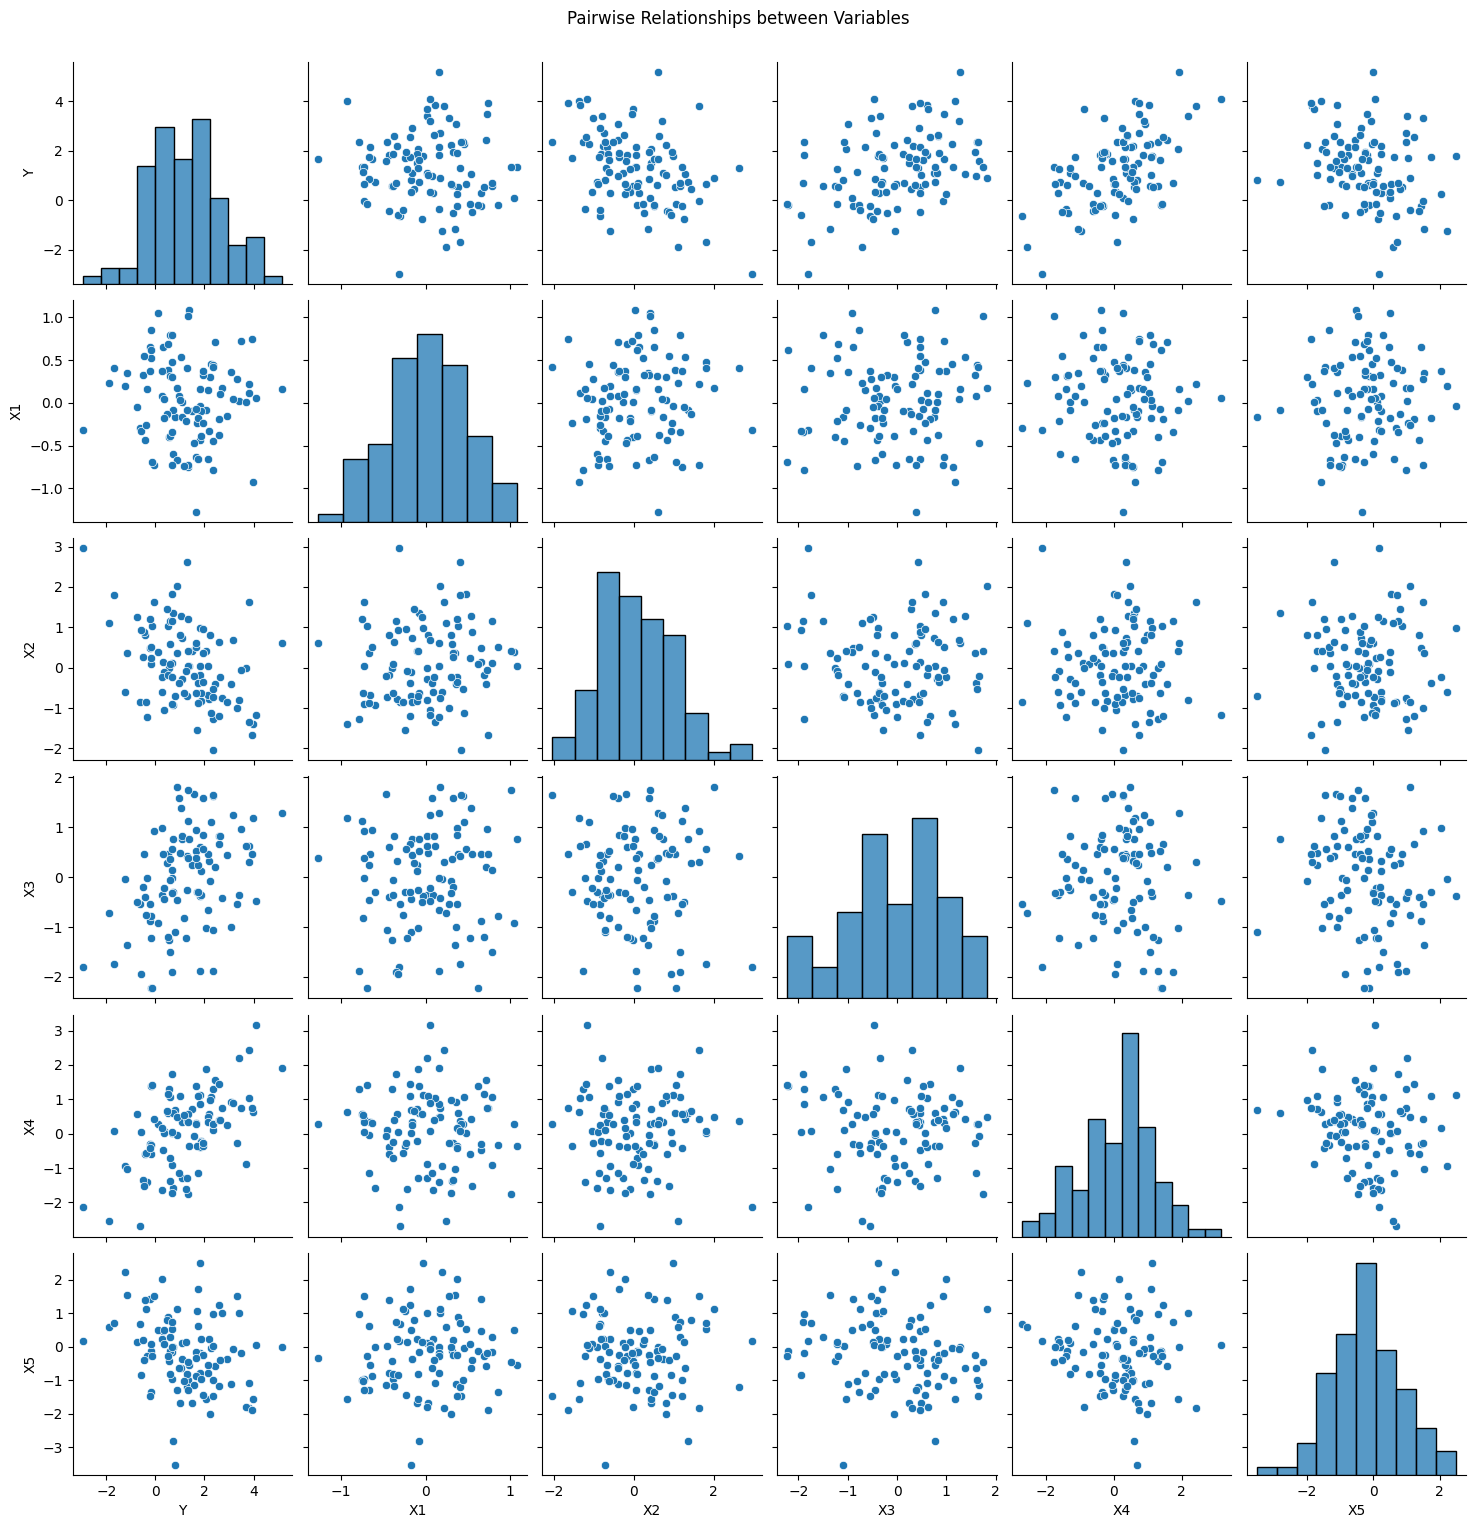

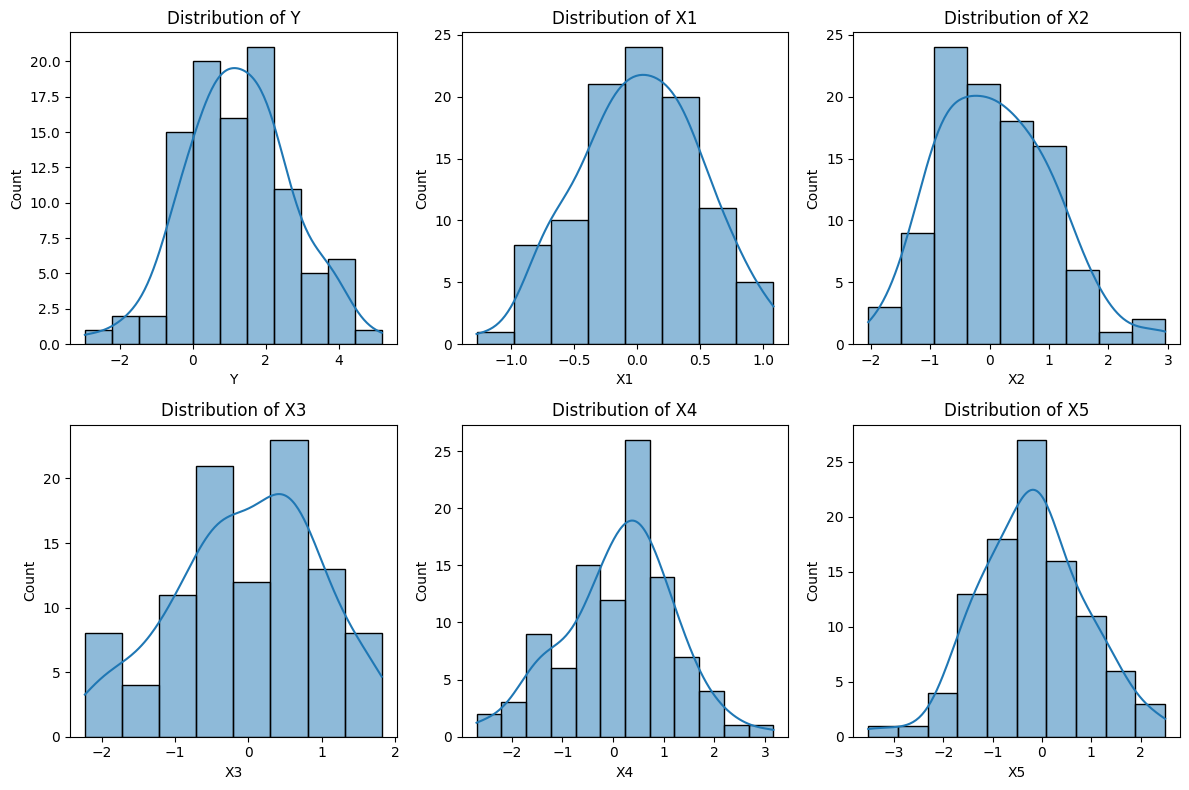

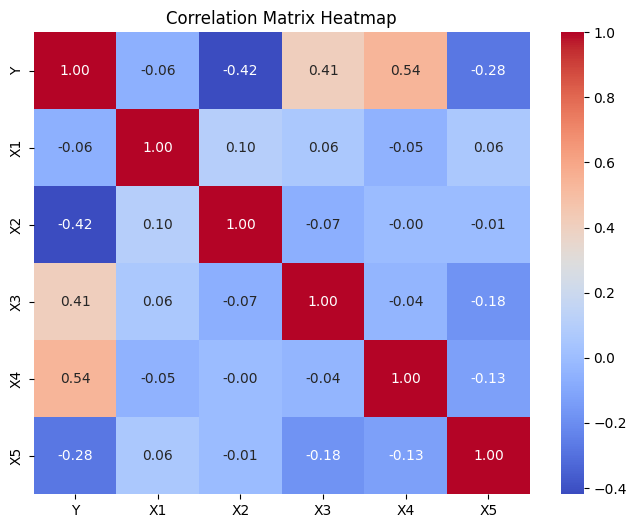

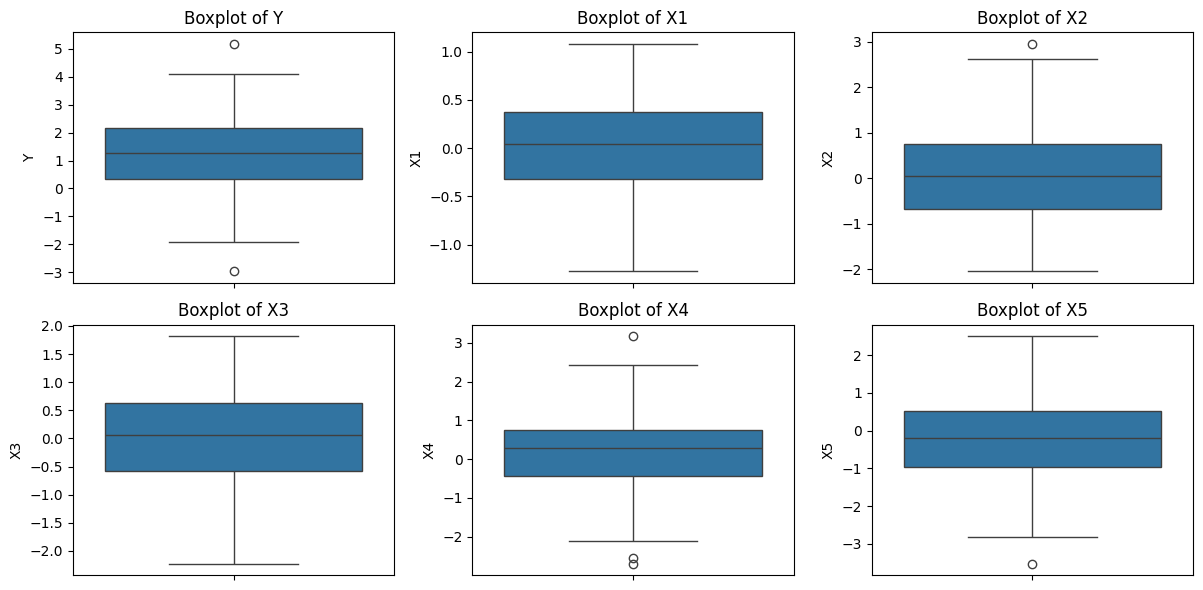

In [ ]:
# Pairplot
plt.figure(figsize=(10, 8))
sns.pairplot(df)
plt.suptitle('Pairwise Relationships between Variables', y=1.02)
plt.show()


# Histograms
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


# Boxplots (optional, depending on observations from other plots)
plt.figure(figsize=(12, 6))
for i, col in enumerate(df.columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

**Q5**

[*********************100%***********************]  1 of 1 completed


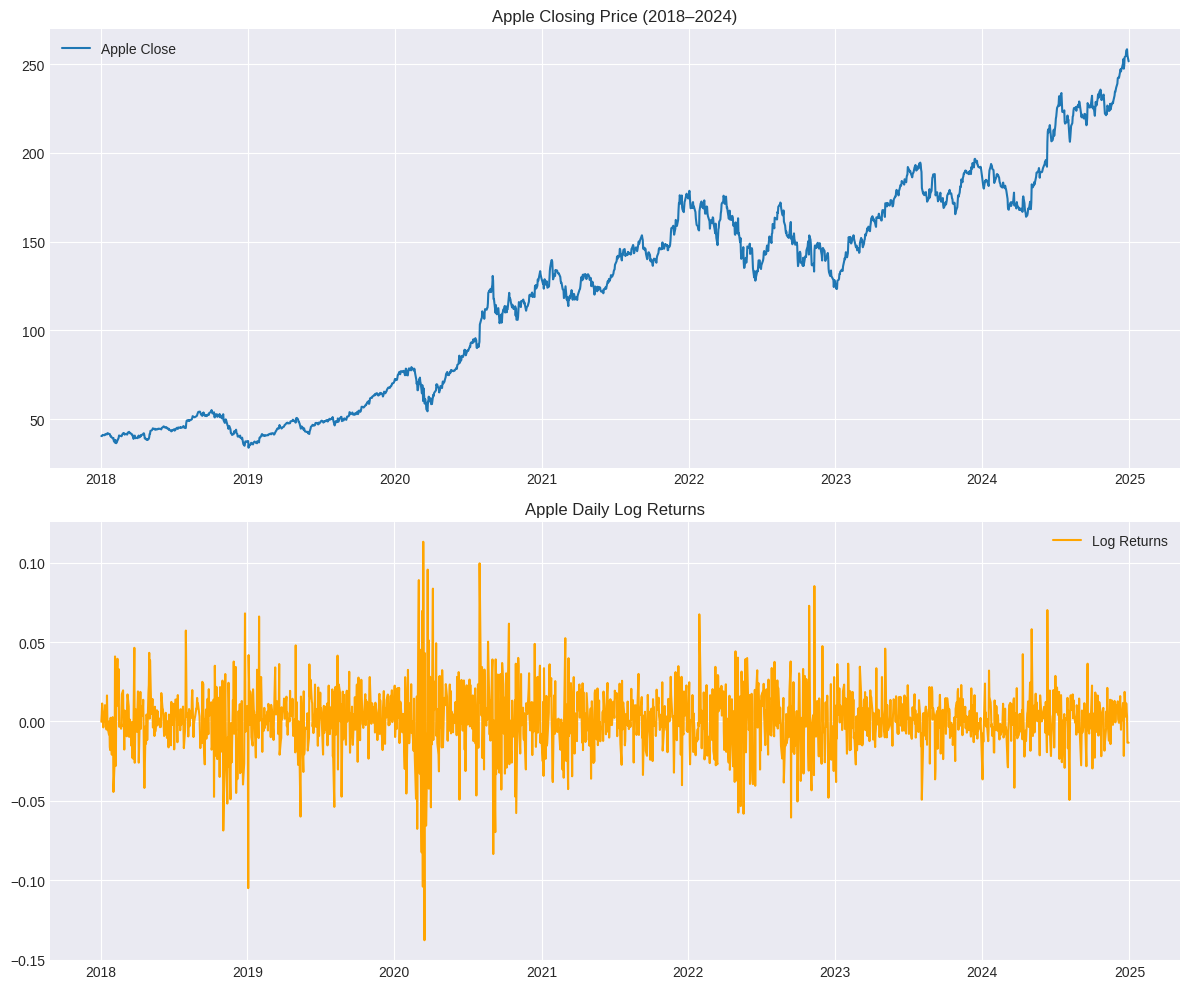


ADF Test on Apple Price Series
Test Statistic : 0.0830
p-value        : 0.9649
Critical Values:
  1%: -3.4341
  5%: -2.8632
  10%: -2.5676

ADF Test on Apple Log Returns
Test Statistic : -13.1479
p-value        : 0.0000
Critical Values:
  1%: -3.4341
  5%: -2.8632
  10%: -2.5677


In [ ]:
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

# Download S&P 500 data from Yahoo Finance
data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
spx_close = data['Close'].dropna()

# Calculate log returns using pandas
spx_log_returns = np.log(spx_close / spx_close.shift(1)).dropna()

# Perform ADF tests
adf_price = adfuller(spx_close)
adf_return = adfuller(spx_log_returns)

# Plot original price and log returns
plt.style.use('seaborn-v0_8-darkgrid')
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plot S&P 500 price
axs[0].plot(spx_close, label='Apple Close')
axs[0].set_title("Apple Closing Price (2018–2024)")
axs[0].legend()

# Plot log returns
axs[1].plot(spx_log_returns, label='Log Returns', color='orange')
axs[1].set_title("Apple Daily Log Returns")
axs[1].legend()

plt.tight_layout()
plt.show()

# Print ADF test results
def print_adf_result(name, result):
    print(f"\n{name}")
    print(f"Test Statistic : {result[0]:.4f}")
    print(f"p-value        : {result[1]:.4f}")
    print("Critical Values:")
    for key, val in result[4].items():
        print(f"  {key}: {val:.4f}")

print_adf_result("ADF Test on Apple Price Series", adf_price)
print_adf_result("ADF Test on Apple Log Returns", adf_return)


In [ ]:
# Simulate data
np.random.seed(42)
t = np.arange(1, 21)
X = np.random.normal(size=20)
beta1, beta2 = 2, 5
alpha = 1

# Create structural break
Y = np.where(t <= 10, alpha + beta1 * X, alpha + beta2 * X) + np.random.normal(scale=0.5, size=20)

# Create DataFrame
df = pd.DataFrame({'Y': Y, 'X': X})
df['D'] = (t > 10).astype(int)               # Dummy variable
df['Z'] = df['D'] * df['X']                  # Interaction term

# Run single regression with dummy interaction
X_reg = sm.add_constant(df[['X', 'Z']])
model = sm.OLS(df['Y'], X_reg).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     501.1
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           7.73e-16
Time:                        13:53:40   Log-Likelihood:                -13.083
No. Observations:                  20   AIC:                             32.17
Df Residuals:                      17   BIC:                             35.15
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8708      0.149      5.854      0.0